In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset, dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [3]:
def split(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
    size = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*size))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*size))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*size))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*size))
    return train_dataset,val_dataset,test_dataset
    

In [4]:
TRAIN_RATIO=0.6
VAL_RATIO=0.2
TEST_RATIO=0.2
# dataset = tf.data.Dataset.range(10)
train_dataset,val_dataset,test_dataset = split(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

DATA VISUALIZATION

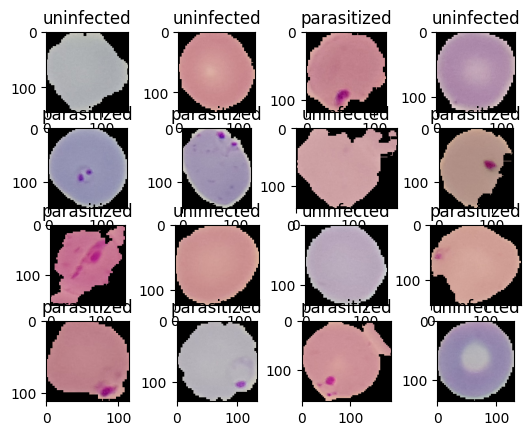

In [5]:
for i,(image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

DATA PREPARATION

In [6]:
IM_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255,label

In [7]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [8]:
for image,label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [9]:
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
# test_dataset = test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

MODEL CREATION STARTED

In [12]:
model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
        
        Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=2,strides=2),

        Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=2,strides=2),

        Flatten(),
        
        Dense(1000,activation='relu'),
        BatchNormalization(),

        Dense(100,activation='relu'),
        BatchNormalization(),

        Dense(1,activation='sigmoid'),
    ]
)
model.summary()

C:\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d (Conv2D)              │ (None, 222, 222, 6)  │         168 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization          │ (None, 222, 222, 6)  │          24 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d (MaxPooling2D) │ (None, 111, 111, 6)  │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_1 (Conv2D)            │ (None, 109, 109, 16) │         880 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_1        │ (None, 109, 109, 16) │          64 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_1              │ (None, 54, 54, 16)   │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ flatten (Flatten)            │ (None, 46656)        │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense (Dense)                │ (None, 1000)         │  46,657,000 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_2        │ (None, 1000)         │       4,000 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense_1 (Dense)              │ (None, 100)          │     100,100 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ batch_normalization_3        │ (None, 100)          │         400 │
│ (BatchNormalization)         │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense_2 (Dense)              │ (None, 1)            │         101 │
└──────────────────────────────┴──────────────────────┴─────────────┘

 Total params: 46,762,737 (178.39 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [13]:
y_true = np.array([0,1,0,0])
y_pred = np.array([0.6,0.51,0.94,1])
bce = BinaryCrossentropy()
bce(y_true,y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=5.0863576>

In [14]:
model.compile(optimizer=Adam(learning_rate=0.1),loss=BinaryCrossentropy(),metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=1,verbose=1)

517/517 ━━━━━━━━━━━━━━━━━━━━ 367s 706ms/step - accuracy: 0.6404 - loss: 0.6832 - val_accuracy: 0.4997 - val_loss: 3.7895


MODEL EVALUATION AND TESTING

In [18]:
test_dataset = test_dataset.batch(1)

In [19]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [4]:

model.evaluate(test_dataset)

NameError: name 'model' is not defined

MODEL SUBCLASSING

In [14]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor,self).__init__()
        self.conv_1=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)
        self.batch_1=BatchNormalization()
        self.pool_1=MaxPool2D(pool_size,strides=2*strides)

        self.conv_1=Conv2D(filters=2*filters,kernel_size=kernel_size,strides=strides,padding=padding,activation=activation)
        self.batch_2=BatchNormalization()
        self.pool_2=MaxPool2D(pool_size,strides=2*strides)
 
    def call(self,x,training):
         x = self.conv_1(x)
         x = self.batch_1(x)
         x = self.pool_1(x)

         x = self.conv_2(x)
         x = self.batch_2(x)
         x = self.pool_2(x)

         return x
feature_sub_classed = FeatureExtractor(8,3,1,"valid","relu",2)

CUSTOM LAYERS

In [5]:
class NeuralLearnDense(Layer):
    def __init__(self,output_units,activation):
        super(NeuralLearnDense,self).__init_()
        self.activation = activation
        self.output_units = output_units

    def build(self,input_features_shape):
        self.ws = self.add_weight(shape = (input_features_shape[-1],self.output_units),initializer='random_normal',trainable=True)
        self.b = self.add_weight(shape = (self.output_units),initializer='random_normal',trainable=True)

    def call(self,input_features):
        pre_output = tf.matmul(input_features,self.w) + self.b
        if (self.activation == 'relu'):
            return tf.nn.relu(pre_output)
        elif (self.activation == 'sigmoid'):
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output
    